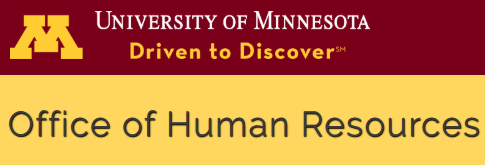

# <span style="color:#ffcc33">This notebook contains analyses that were generated for the Office of Human Resources (henceforth known as OHR) Experiential Learning Project for the University of Minnesota's MSBA 6515 Summer 2020 course.</span>
    
# <span style="color:#ffcc33">The analyses were created using data provided by OHR and ONLY data provided by OHR.  This notebook is not for public consumption and should not be used in any other context than to review the code and the visualizations that were generated for the capstone project.

# <span style="color:#ffcc33">Please do not reproduce or republish this code without written consent of the authors below.</span>

- <b>Course</b>: <i>MSBA 6515 - Capstone Project in Analytics</i>
- <b>Semester</b>: <i>Summer 2020</i>
- <b>CAL Team</b>: <i># 1</i>
- <b>Authors</b>: 
<br><i>Danny Moncada, MSBA 2020 - Data Engineer</i>

# <span style="color:#ffcc33">OHR  Staff Modeling</span>

- Start with Python kernel
- Load the appropriate libraries
- Load the data (files)
- Conform data to be used in machine learning pipeline
- Normalize & clean up NULL values
- Build functions for setting up new classifiers and hyperparameter settings
- Generate classifiers based on seven different algorithms
- Determine what models are working
- Print out classification reports
- Display the Feature Importances
- Show a Lift Curve for each classifier

In [1]:
## Provide a wider display for easier viewing
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
## For plotting distributions at the end
%matplotlib inline

## System env
import sys

## Data Cleaning
import pandas as pd
import numpy as np

## Plotting
import matplotlib.pyplot as plt
import matplotlib

## For garbage collection & regex
import gc
import re

## Import the ML libraries
import sklearn
import scikitplot as skplt
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, cohen_kappa_score, roc_curve, precision_recall_curve, make_scorer, precision_score
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, StratifiedKFold, KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, Normalizer, MinMaxScaler, RobustScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline

In [3]:
## Show the Python environment details
print("Here are the environment details...")
print()
print(sys.executable)
print(sys.version)
print(sys.version_info)

## Show the different versions for each library used in the Python exploration
print()
print("This notebook is using pandas version: {}.".format(pd.__version__))
print("This notebook is using numpy version: {}.".format(np.__version__))
print("This notebook is using matplotlib version: {}.".format(matplotlib.__version__))
print("This notebook is using sklearn version: {}".format(sklearn.__version__))

Here are the environment details...

C:\Python\envs\ohr_2020\python.exe
3.7.7 (default, May  6 2020, 11:45:54) [MSC v.1916 64 bit (AMD64)]
sys.version_info(major=3, minor=7, micro=7, releaselevel='final', serial=0)

This notebook is using pandas version: 0.25.3.
This notebook is using numpy version: 1.18.5.
This notebook is using matplotlib version: 3.2.2.
This notebook is using sklearn version: 0.23.1


In [4]:
## Remove some warnings for pandas - they clutter the notebook
import warnings
warnings.simplefilter(action='ignore', category=[FutureWarning, DeprecationWarning])

import warnings
warnings.filterwarnings("ignore")

In [5]:
## Find and load the data files first

team_folder = "D:/Shared Group Folder/Modeling - Staff/"

## Load classifier data set with all churned employees from 2015 to current day
classifer_set = "All_Churned_Staff_w_Current_Active_Employees.csv"

# <span style="color:#ffcc33">Data Loading, Standardization, & Pre-Processing</span>

- Load classifier set with all churned employees to use for model learning
- Standardize the feature set
- Split into training/test sets
- Run through seven algorithms to determine the best performing model

In [6]:
## Load in our classifier set - one of our original tables

classifier_df = pd.read_csv(team_folder + classifer_set)

In [7]:
## Look at the columns from our classifier data set

## classifier_df.columns

In [8]:
## Drop any rows that don't belong to Workforce Action Reason = Resignation 

classifier_df = classifier_df.drop(classifier_df[(classifier_df["TARGET"] == 1) & (classifier_df["WKFC_ACTN_RSN_LD"] != 'Resignation')].index)

In [9]:
## View the class imbalance for Staff over the whole 5 year period data set

classifier_df.groupby(["TARGET"]).EMPLID.nunique()

TARGET
0    12841
1     2875
Name: EMPLID, dtype: int64

In [10]:
## Over the five years of data!

2875 / 12841 * 100

22.389222023206916

In [11]:
## Set columns to focus on

## Create a categorical values column set
## Create a numerical values column set

## Select & Standardize Feature Set

- This can be changed by the analyst based on the data set available
- As new features are introduced to the model, there will be a need to tweak / make adjustments here

In [12]:
## Set the numeric features here
numeric_features = ["NUM_SUPS", "SUP_NUM_RPTS", "JOB_COUNT", "PAY", "NUM_RAISES", "TIME_TO_LST_RAISE", "WEEKS_UMN"]

- Normalization is the process of scaling individual samples to have unit norm; many machine learning estimators might behave badly if the individual features do not more or less look like standard normally distributed data. <br><br>
- Here are some examples:

    - `Normalizer(norm = "l1")`
    - `RobustScaler()`
    - `PowerTransformer(method='yeo-johnson', standardize=False)`
    - `StandardScaler()`

In [13]:
## Create a function for selecting a specific scaler

def numeric_transformation(scaling = "standard"):
    
    if scaling == "standard":
        numeric_transformer = Pipeline(steps = [("scaler", StandardScaler())])
        
    elif scaling == "norm":
        numeric_transformer = Pipeline(steps = [("scaler", Normalizer(norm = "l1"))])
        
    elif scaling == "robust":
        numeric_transformer = Pipeline(steps = [("scaler", RobustScaler())])
        
    elif scaling == "power":
        numeric_transformer = Pipeline(steps = [("scaler", PowerTransformer(method = "yeo-johnson", standardize = False))])
        
    return numeric_transformer

In [14]:
## Create a new numeric transfomer

numeric_transformer = numeric_transformation()

- Encode categorical features as a one-hot numeric array.  This encoding is needed for feeding categorical data to many scikit-learn estimators, notably linear models and SVMs with the standard kernels.<br><br>

- The input to this transformer should be an array-like of integers or strings, denoting the values taken on by categorical (discrete) features. The features are encoded using a one-hot (aka 'one-of-K' or 'dummy) encoding scheme. This creates a binary column for each category and returns a sparse matrix or dense array (depending on the sparse parameter).

In [15]:
## Set the categorical features to be used in model training here
categorical_features = ["WKFC_CATGY_DESC", "ZDEPTID_LD", "RPT_TO_TTL"]

In [16]:
## Create a function for selecting OneHotEncoding

def categorical_transformation(strategy = "onehot"):
    
    if strategy == "onehot":
        categorical_transformer = Pipeline(steps = [("onehot", OneHotEncoder(handle_unknown = "ignore", sparse = False))])
        
    return categorical_transformer

In [17]:
categorical_transformer = categorical_transformation()

In [18]:
## Add the two feature sets together
all_cols = categorical_features + numeric_features

## Subset the dataframe to just the columns required for classification
subset_df = classifier_df[all_cols]

## Prior to encoding the Categorical Features, view a correlation matrix to confirm the features are not highly correlated with one another.

- If we see an issue, we need to flag it so that we don't include that feature in the training

In [19]:
## Prior to running the model, look to see what features are correlated

subset_df.join(classifier_df["TARGET"]).corr().style.background_gradient(cmap = "coolwarm").set_precision(4)

,NUM_SUPS,SUP_NUM_RPTS,JOB_COUNT,PAY,NUM_RAISES,TIME_TO_LST_RAISE,WEEKS_UMN,TARGET
NUM_SUPS,1,-0.03515,0.07682,0.03819,0.2648,-0.1203,0.1002,-0.157
SUP_NUM_RPTS,-0.03515,1,0.006564,0.1031,0.03284,0.07091,0.03715,0.01772
JOB_COUNT,0.07682,0.006564,1,0.1749,0.03834,-0.002624,0.01326,-0.004744
PAY,0.03819,0.1031,0.1749,1,0.1801,-0.04957,0.2015,-0.1273
NUM_RAISES,0.2648,0.03284,0.03834,0.1801,1,-0.2885,0.5771,-0.3164
TIME_TO_LST_RAISE,-0.1203,0.07091,-0.002624,-0.04957,-0.2885,1,0.01076,0.6245
WEEKS_UMN,0.1002,0.03715,0.01326,0.2015,0.5771,0.01076,1,-0.1362
TARGET,-0.157,0.01772,-0.004744,-0.1273,-0.3164,0.6245,-0.1362,1


## Create our X, y variables and split them in order to train the models below

- Use a 66/33 percent split on the entire data set
- When looking at smaller windows, we may not need this step, so create a function for it

In [20]:
## Create our X and y variables for training
X = subset_df

## Use the TARGET column from the classifier dataframe as our 'Y' or prediction
y = classifier_df["TARGET"]

In [21]:
## Define a function for splitting the data
## This may not be need if the data is already split beforehand

def my_train_test_split(X, y, test_size = .33):

    ## Set a random seed
    seed = 42
    ## Set the test size
    
    ## Split the data per the test size
    X_train, X_test, y_train, y_test =\
        train_test_split(X, y, test_size = test_size, random_state = seed)
    
    ## Return the four data sets required for training
    return X_train, X_test, y_train, y_test

In [22]:
## Create the data sets needed for training the models

X_train, X_test, y_train, y_test = my_train_test_split(X, y)

In [23]:
## Fill in any possible NA values; this should be handled in the table generation step but one last check doesn't hurt

X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

In [24]:
## Set up the preprocessing steps for the Pipeline

preprocessor = ColumnTransformer(transformers = [
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)],
        remainder = "passthrough")

## Create a custom scorer for all of our models

- We are trying maximize precision (TP + FP / TP)
- Sample confusion matrix to help with understand the differences

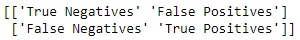

In [25]:
## Precision is the closeness of measurements to each other

custom_scorer = make_scorer(precision_score, greater_is_better = True,  pos_label = 1)

## Create an `obs_weight` variable to help with the imbalance of classes in the XGBoost Classifier

In [26]:
import math

def create_obs_weight():

    negative = (classifier_df["TARGET"] == 0).astype(np.int_).sum()
    positive = (classifier_df["TARGET"] == 1).astype(np.int_).sum()

    obs_weight = math.sqrt(negative/positive)
    return obs_weight

## Call the function and save as a variable to be used further down
obs_weight = create_obs_weight()

## Create two functions to perform evaluation of model performance

- 1. `model_outcomes`: Print out confusion matrix and Kappa statistic for each model
- 2. `plot_feature_importance`: plots the top 20 model feature importances

In [27]:
def model_outcomes(model, score, X_test, y_test):

    ## Show the best score from the XGBClassifier
    print("The best precision score from the model GridSearch is: {:.5f}.".format(score))
    print()

    ## Make predictions on using the best model
    ## This will inform us whether the model needs tuning
    preds = model.predict(X_test)
    preds_bin = (preds > 0.5).astype(np.int_)

    ## Print the confusion matrix
    print(confusion_matrix(y_test,preds_bin))
    ## Give some instructions on how to read it
    print('\nHow to read a confusion matrix:')
    print(np.array([['True Negatives','False Positives'],['False Negatives','True Positives']]))

    print()
    print(classification_report(y_test, preds_bin))

    ## Print the kappa statistic for the Staff Classifier
    classifier_kappa = cohen_kappa_score(y_test, preds, labels = None)
    print("The Kappa statistic score based on the best model is: {}".format(classifier_kappa))

In [28]:
def plot_feature_importance(pipelined_model, X_train, column_names, model_type = "tree"):
    
    ## Plot the feature importance
    fig, ax = plt.subplots(figsize = (15, 8))

    ## Save the feature importance to a var
    ## Split into three booleans for the different classifiers
    
    if model_type == "tree":
    ## Only save the top 20!  This will be important when we have lots of features
    ## Need to extract the model from the pipeline to get the feature importances
        importances = pipelined_model.steps[1][1].feature_importances_[0:20]
    
    elif model_type == "lr":
        importances = pipelined_model.steps[1][1].coef_[0][0:20]
        
    ##elif model_type == "knn":
      ##  results = permutation_importance(model, X_train, y_train, scoring = custom_scorer)
      ##  importances = results.importances_mean[0:20]
        
    ## Sort the features in descending order
    indices = np.argsort(importances)
    ## Get the column names for the feature importance
    names = [column_names[i] for i in indices] ## Column names are generated from fitting the first Pipeline and obtaining the transformed feature names
    
    ## For the plots
    ## Put a title for Feature Importance
    plt.title("Feature Importance")
    ## Add bars to bar graph
    plt.barh(np.arange(0, 20), importances[indices])
    ## Add feature names to x-axis
    plt.yticks(np.arange(0, 20), names)
    ## Show the vis!
    plt.show()

## Create function to create a GridSearchCV instance

- Use the new preprocessor to standardize the data prior to training the models

In [29]:
import time

def grid_search_cv(preprocessor, clf, params, X_train, y_train):
    
    ## Start a timer to see the training time
    start = time.perf_counter()
    
    pipelined_clf = Pipeline(steps = [("preprocessor", preprocessor),
                           ("classifier", clf)])
    
    ## Run through GridSearch to select the best model based on the parameter set
    grid = GridSearchCV(
                    pipelined_clf, ## Classifier
                    params, ## Param set
                    n_jobs = 20, ## When in production, increase
                    scoring = custom_scorer,
                    cv = 5,
                    verbose = 2) ## To view the computation time
    
    grid.fit(X_train, y_train)
    
    ## Set an end time
    end = time.perf_counter()
    
    ## Save the best model for evaluation
    model = grid.best_estimator_
    
    ## Save the best score for evaluation
    best_score = grid.best_score_
    
    ## Display the run time
    print("The GridSearchCV took {:.2f} minutes to complete.".format((end-start)/ 60))
    
    return pipelined_clf, model, best_score

## Train the data set through various models

- 1.  XGBoost Classifier
- 2.  Logistic Regression Classifier
- 3.  <i>k</i>-NN Classifier
- 4.  Decision Tree Classifier
- 5.  Random Forest Classifier
- 6.  SVM Classififer
- 7.  Light GBM Classifier

## 1.  XGBoost Classifier

In [30]:
## Import XGBoost
import xgboost as xgb

def xgboost_clf():

    ## Create a new classifier
    xgb_clf = xgb.XGBClassifier()

    ## Set up the parameters for XGBoost
    params = [{
                        "classifier__eta"    : [0.10] ,
                        "classifier__max_depth"        : [6, 9],
                        "classifier__min_child_weight" : [1],
                        "classifier__gamma"            : [0.2, 0.3],
                        "classifier__colsample_bytree" : [0.6, 0.9],
                        "classifier__scale_pos_weight" : [obs_weight],
                        "classifier__objective" : ['binary:logistic'],
                        "classifier__lambda" : [1],
                        "classifier__alpha" : [0]
                                         }]
    
    return xgb_clf, params

In [31]:
xgb_clf, xgb_params = xgboost_clf()

In [32]:
xgb_pipeline, xgb_model, xgb_score = grid_search_cv(preprocessor, xgb_clf, xgb_params, X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:   40.9s
[Parallel(n_jobs=20)]: Done  22 out of  40 | elapsed:  2.1min remaining:  1.7min
[Parallel(n_jobs=20)]: Done  40 out of  40 | elapsed:  3.5min finished


The GridSearchCV took 4.61 minutes to complete.


In [33]:
## Once the XGB model is fitted, we need to grab the categorical features that were encoded for the feature importance

encoded_features = list(xgb_model.named_steps["preprocessor"].named_transformers_["cat"].named_steps["onehot"].get_feature_names(input_features = categorical_features))

## Save the column names to a variable to be used in the call to the feature importance plot function
column_names = numeric_features + encoded_features

###  1A. Show the Confusion Matrix

In [34]:
model_outcomes(xgb_model, xgb_score, X_test, y_test)

The best precision score from the model GridSearch is: 0.85746.

[[4110  107]
 [ 184  786]]

How to read a confusion matrix:
[['True Negatives' 'False Positives']
 ['False Negatives' 'True Positives']]

              precision    recall  f1-score   support

           0       0.96      0.97      0.97      4217
           1       0.88      0.81      0.84       970

    accuracy                           0.94      5187
   macro avg       0.92      0.89      0.90      5187
weighted avg       0.94      0.94      0.94      5187

The Kappa statistic score based on the best model is: 0.8096804409957381


### 1B. Plot the Feature Importance

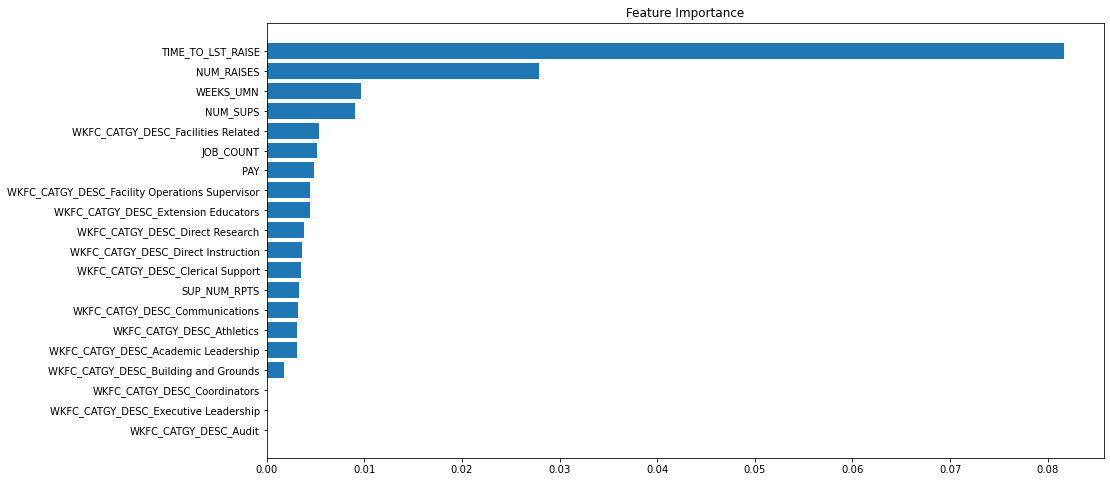

In [35]:
plot_feature_importance(xgb_model, X_train, column_names, model_type = "tree")

# 2.  Logistic Regression Classifier

In [36]:
## Import Logistic Regression
from sklearn.linear_model import LogisticRegression

## Create a function to build a classifier
def lr_clf():
    
    ## Create a new classifier and set a seed so that we can replicate results
    lr_clf = LogisticRegression(random_state = 42)
    
    ## Set up the parameters for Logistic Regression
    params = {
                    "classifier__C": np.logspace(-3,3,7), 
                    "classifier__penalty": ["none","l2"]
                                     }
    ## Return the new classifier and params
    return lr_clf, params

In [37]:
## Call the function to get a new Logistic Regression Classifier

lr_clf, lr_params = lr_clf()

In [38]:
## Call the function to train a new LR Classifier

lr_pipeline, lr_model, lr_score = grid_search_cv(preprocessor, lr_clf, lr_params, X_train, y_train)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:    5.3s
[Parallel(n_jobs=20)]: Done  67 out of  70 | elapsed:  1.9min remaining:    4.9s
[Parallel(n_jobs=20)]: Done  70 out of  70 | elapsed:  1.9min finished


The GridSearchCV took 1.97 minutes to complete.


### 2.  Show the Confusion Matrix

In [39]:
model_outcomes(lr_model, lr_score, X_test, y_test)

The best precision score from the model GridSearch is: 0.94441.

[[4198   19]
 [ 576  394]]

How to read a confusion matrix:
[['True Negatives' 'False Positives']
 ['False Negatives' 'True Positives']]

              precision    recall  f1-score   support

           0       0.88      1.00      0.93      4217
           1       0.95      0.41      0.57       970

    accuracy                           0.89      5187
   macro avg       0.92      0.70      0.75      5187
weighted avg       0.89      0.89      0.87      5187

The Kappa statistic score based on the best model is: 0.515682550423302


###  3.  Show the Feature Importance

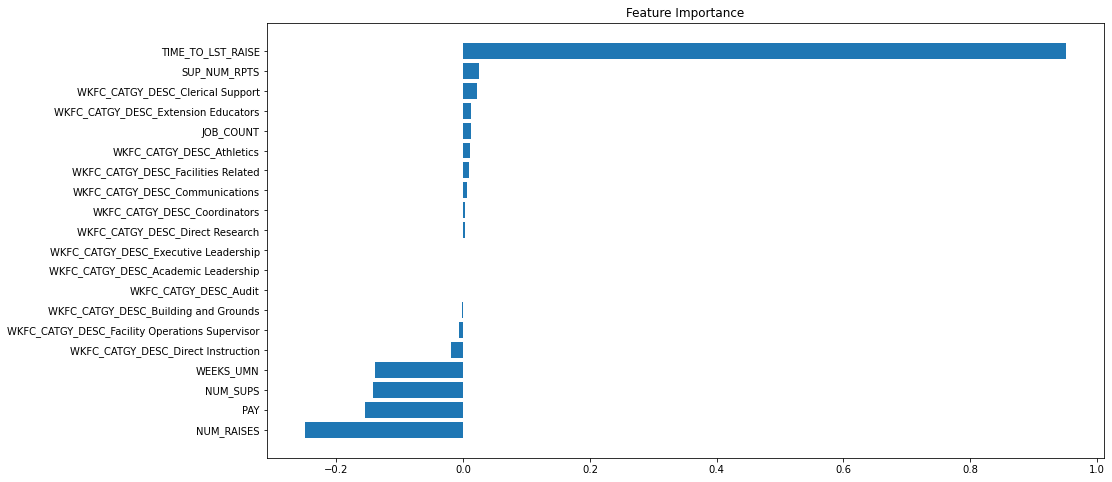

In [40]:
## Plot the feature importance

plot_feature_importance(lr_model, X_train, column_names, model_type = "lr")

# 3.  KNN - <i>k</i> Nearest Neighbors Classifier

In [41]:
## Import kNN classifier

from sklearn.neighbors import KNeighborsClassifier

def knn_clf():
    
    ## Initialize new instance of classifier
    knn_clf = KNeighborsClassifier()

    ## Set up the parameters for XGBoost
    params = {
                    "classifier__n_neighbors": [3, 5, 11, 19],
                    "classifier__weights": ["uniform", "distance"],
                    "classifier__metric": ["euclidean","manhattan"]
                                     }
    
    return knn_clf, params

In [42]:
knn_clf, knn_params = knn_clf()

In [43]:
## Call the function to train a new kNN Classifier

knn_pipeline, knn_model, knn_score = grid_search_cv(preprocessor, knn_clf, knn_params, X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:   46.2s
[Parallel(n_jobs=20)]: Done  80 out of  80 | elapsed:  7.8min finished


The GridSearchCV took 7.95 minutes to complete.


### 3A.  Show the Confusion Matrix

In [44]:
model_outcomes(knn_model, knn_score, X_test, y_test)

The best precision score from the model GridSearch is: 0.93630.

[[4187   30]
 [ 410  560]]

How to read a confusion matrix:
[['True Negatives' 'False Positives']
 ['False Negatives' 'True Positives']]

              precision    recall  f1-score   support

           0       0.91      0.99      0.95      4217
           1       0.95      0.58      0.72       970

    accuracy                           0.92      5187
   macro avg       0.93      0.79      0.83      5187
weighted avg       0.92      0.92      0.91      5187

The Kappa statistic score based on the best model is: 0.6714782528587386


###  3B.  Show the Feature Importance

- `kNN` model needs to be re-trained in order to show the feature importance; to save computation time we will exclude this step

In [45]:
## Plot the feature importance

## plot_feature_importance(knn_model, X_train, column_names, model_type = "knn")

# 4.  Decision Tree Classifier

In [46]:
## Import a new DT Classifier
from sklearn.tree import DecisionTreeClassifier

def dt_clf():
    
    ## Define a new DT instances & set a seed to reproduce the results
    dt_clf = DecisionTreeClassifier(random_state = 42)
    
    params = {
        "classifier__max_leaf_nodes": list(range(80, 100)), 
        "classifier__min_samples_split": [2, 3, 4],
        "classifier__max_depth": np.arange(8)+1
                }
    
    return dt_clf, params

In [47]:
## Initialize new DT instance

dt_clf, dt_params = dt_clf()

In [48]:
## Call the function to train a new LR Classifier

dt_pipeline, dt_model, dt_score = grid_search_cv(preprocessor, dt_clf, dt_params, X_train, y_train)

Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=20)]: Done 122 tasks      | elapsed:    9.7s
[Parallel(n_jobs=20)]: Done 325 tasks      | elapsed:   25.0s
[Parallel(n_jobs=20)]: Done 608 tasks      | elapsed:   55.6s
[Parallel(n_jobs=20)]: Done 973 tasks      | elapsed:  1.7min
[Parallel(n_jobs=20)]: Done 1418 tasks      | elapsed:  3.0min
[Parallel(n_jobs=20)]: Done 1945 tasks      | elapsed:  4.9min
[Parallel(n_jobs=20)]: Done 2400 out of 2400 | elapsed:  6.7min finished


The GridSearchCV took 6.73 minutes to complete.


### 4A.  Show the Confusion Matrix

In [49]:
model_outcomes(dt_model, dt_score, X_test, y_test)

The best precision score from the model GridSearch is: 0.91809.

[[4164   53]
 [ 318  652]]

How to read a confusion matrix:
[['True Negatives' 'False Positives']
 ['False Negatives' 'True Positives']]

              precision    recall  f1-score   support

           0       0.93      0.99      0.96      4217
           1       0.92      0.67      0.78       970

    accuracy                           0.93      5187
   macro avg       0.93      0.83      0.87      5187
weighted avg       0.93      0.93      0.92      5187

The Kappa statistic score based on the best model is: 0.7371258208939933


### 4B.  Show the Feature Importance

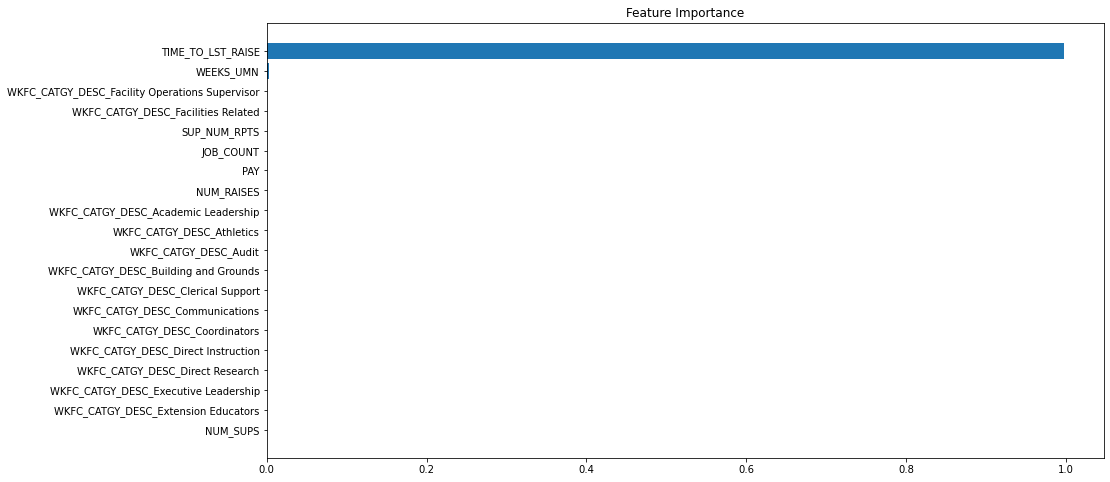

In [50]:
## Plot the feature importance

plot_feature_importance(dt_model, X_train, column_names, model_type = "tree")

# 5. Random Forest Classifier

In [51]:
## Import in Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

def rf_clf():
    
    ## Define a new RF instance & set a seed to reproduce the results
    rf_clf = RandomForestClassifier(random_state = 42)
    
    params = {
        "classifier__n_estimators": [400, 700, 1000],
        "classifier__max_depth": [15, 20, 25],
        "classifier__max_leaf_nodes": [50, 100, 200]
                }
    
    return rf_clf, params

In [52]:
## Initialize new RF instance

rf_clf, rf_params = rf_clf()

In [53]:
## Call the function to train a new RF Classifier

rt_pipeline, rt_model, rt_score = grid_search_cv(preprocessor, rf_clf, rf_params, X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:   40.2s
[Parallel(n_jobs=20)]: Done 135 out of 135 | elapsed: 13.9min finished


The GridSearchCV took 15.08 minutes to complete.


### 5A.  Show the Confusion Matrix

In [54]:
model_outcomes(rt_model, rt_score, X_test, y_test)

The best precision score from the model GridSearch is: 1.00000.

[[4217    0]
 [ 901   69]]

How to read a confusion matrix:
[['True Negatives' 'False Positives']
 ['False Negatives' 'True Positives']]

              precision    recall  f1-score   support

           0       0.82      1.00      0.90      4217
           1       1.00      0.07      0.13       970

    accuracy                           0.83      5187
   macro avg       0.91      0.54      0.52      5187
weighted avg       0.86      0.83      0.76      5187

The Kappa statistic score based on the best model is: 0.1107322650674073


###  5B.  Show the Feature Importance

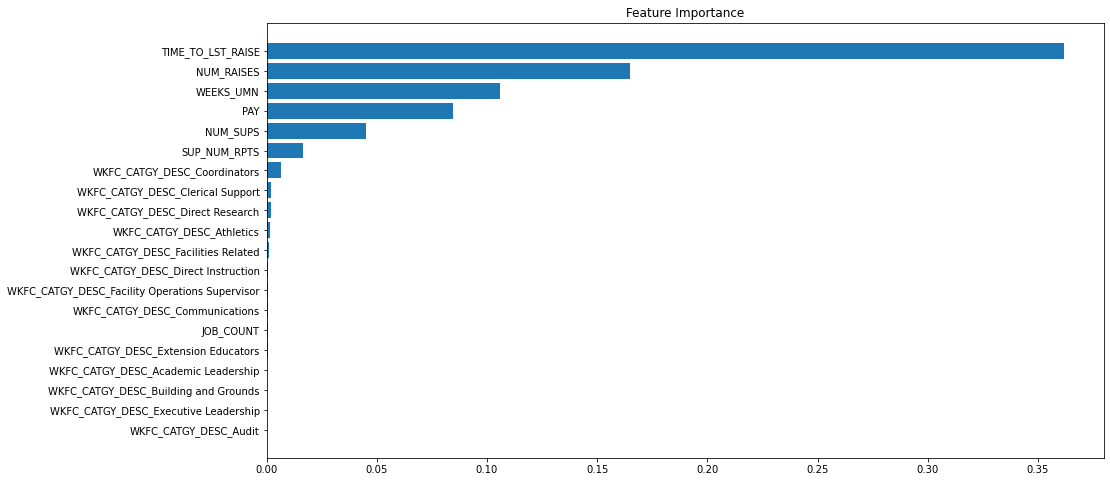

In [55]:
## Plot the feature importance

plot_feature_importance(rt_model, X_train, column_names, model_type = "tree")

# 6.  SVM (Support Vector Machine) Classifier

In [56]:
## Import Support Vector Machine

from sklearn.svm import SVC, LinearSVC

def svc_clf():
    
    ## Define a new SVC instance & set a seed to reproduce the results
    svc_clf = SVC(random_state = 42)
    
    params = {
        "classifier__C": [1, 10, 100, 1000], 
        "classifier__gamma": [0.001, 0.0001], 
        "classifier__kernel": ["linear"]
                }
    
    return svc_clf, params

In [57]:
## Initialize a new instance

svc_clf, svc_params = svc_clf()

In [58]:
## Call the function to train a new SVC Classifier

svc_pipeline, svc_model, svc_score = grid_search_cv(preprocessor, svc_clf, svc_params, X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:  1.5min
[Parallel(n_jobs=20)]: Done  22 out of  40 | elapsed:  5.1min remaining:  4.1min
[Parallel(n_jobs=20)]: Done  40 out of  40 | elapsed: 19.2min finished


The GridSearchCV took 20.15 minutes to complete.


### 6A.  Show the Confusion Matrix

In [59]:
model_outcomes(svc_model, svc_score, X_test, y_test)

The best precision score from the model GridSearch is: 0.90365.

[[4156   61]
 [ 276  694]]

How to read a confusion matrix:
[['True Negatives' 'False Positives']
 ['False Negatives' 'True Positives']]

              precision    recall  f1-score   support

           0       0.94      0.99      0.96      4217
           1       0.92      0.72      0.80       970

    accuracy                           0.94      5187
   macro avg       0.93      0.85      0.88      5187
weighted avg       0.93      0.94      0.93      5187

The Kappa statistic score based on the best model is: 0.7663974074135944


### 6B.  Show the Feature Importance (pending)

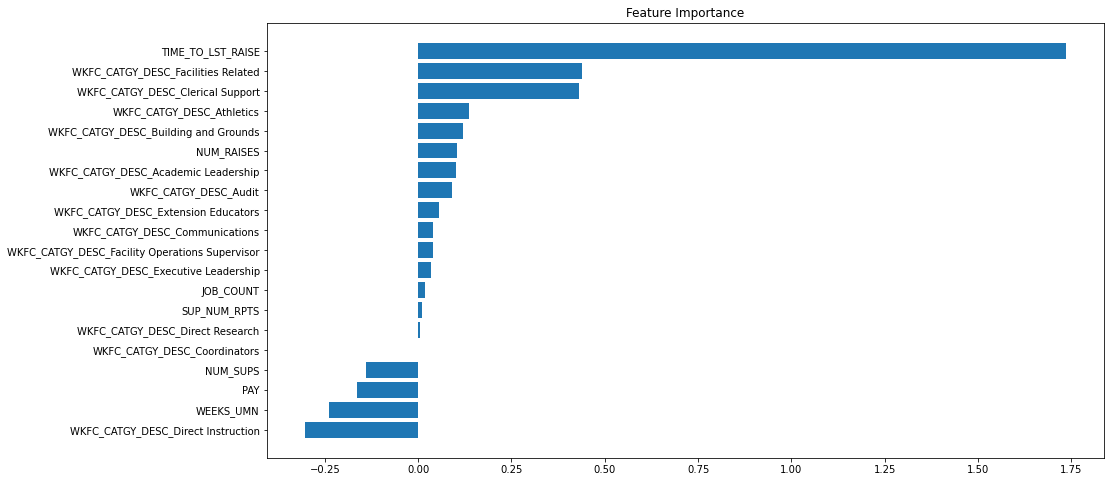

In [60]:
plot_feature_importance(svc_model, X_train, column_names, model_type = "lr")

# 7.  LightGBM Classifier

In [61]:
## Import freshly install LightGBM library as our last classifier

import lightgbm as lgb

def lgb_clf():
    
    ## Create a new classifier
    lgb_clf = lgb.LGBMClassifier(is_unbalanced = True)
    
    ## Set up the parameters for LightGBM
    params = {
                "classifier__n_estimators": [400, 1000],
                "classifier__colsample_bytree": [0.7, 0.8],
                "classifier__max_depth": [15,20,25],
                "classifier__num_leaves": [50, 100, 200],
                "classifier__min_split_gain": [0.3, 0.4]
                            }
    
    return lgb_clf, params

In [62]:
lgb_clf, lgb_params = lgb_clf()

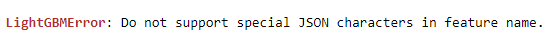

In [63]:
## Prior to running through LightGBM Classifier, we have to remove special characters

X_train = X_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X_test = X_test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [64]:
lgb_pipeline, lgb_model, lgb_score = grid_search_cv(preprocessor, lgb_clf, lgb_params, X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:    3.2s
[Parallel(n_jobs=20)]: Done 122 tasks      | elapsed:  1.0min
[Parallel(n_jobs=20)]: Done 360 out of 360 | elapsed:  2.9min finished


The GridSearchCV took 3.01 minutes to complete.


### 7A.  Show the Confusion Matrix

In [65]:
model_outcomes(lgb_model, lgb_score, X_test, y_test)

The best precision score from the model GridSearch is: 0.88243.

[[4136   81]
 [ 204  766]]

How to read a confusion matrix:
[['True Negatives' 'False Positives']
 ['False Negatives' 'True Positives']]

              precision    recall  f1-score   support

           0       0.95      0.98      0.97      4217
           1       0.90      0.79      0.84       970

    accuracy                           0.95      5187
   macro avg       0.93      0.89      0.90      5187
weighted avg       0.94      0.95      0.94      5187

The Kappa statistic score based on the best model is: 0.8100268338165459


### 7B.  Plot the Feature Importance

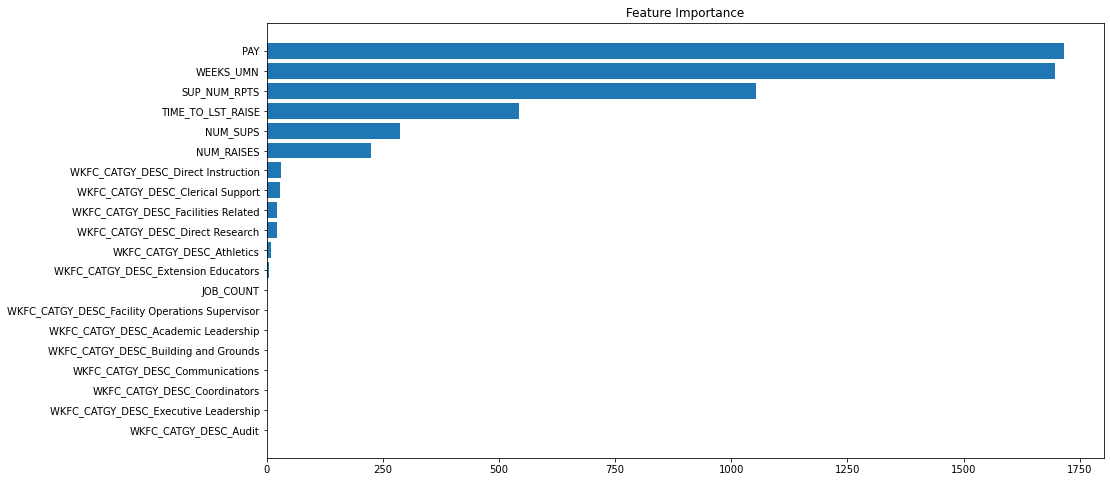

In [66]:
## Plot the feature importance

plot_feature_importance(lgb_model, X_train, column_names, model_type = "tree")

### 7C. Generate Lift Curve for final model

In [67]:
def plot_lift_curve(pipelined_model, X_test, y_test):
    
    ## Plot the Cumulative Gains Curve
    fig, ax = plt.subplots(figsize = (15, 8))
    
    ## Generate probablities for our testing set
    probas_ = pipelined_model.predict_proba(X_test)
    
    ## Thank you sci-kit plotting package!
    skplt.metrics.plot_cumulative_gain(y_test, probas_, ax = ax)
    
    ## Show the viz
    plt.show()

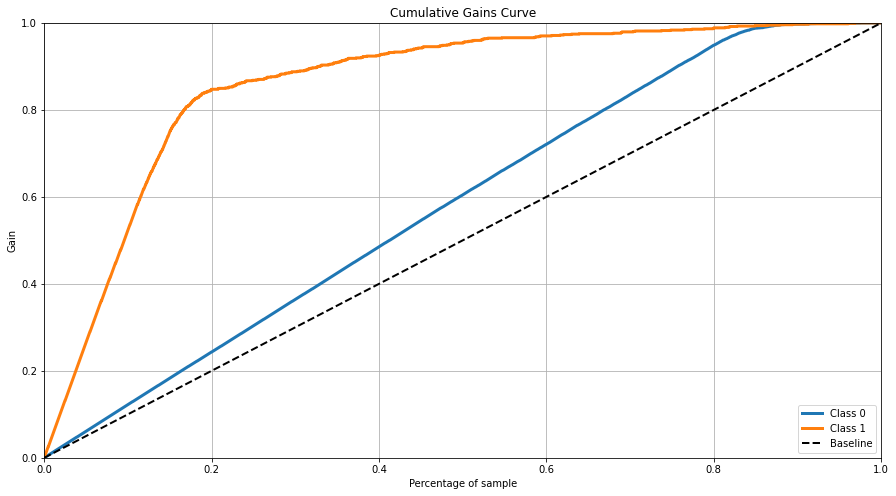

In [68]:
plot_lift_curve(lgb_model, X_test, y_test)

## 7D.  Generate Lift Curve for final LightGBM Model

In [69]:
def plot_lift_curve(pipelined_model, X_test, y_test):
    
    ## Plot the Cumulative Gains Curve
    fig, ax = plt.subplots(figsize = (15, 8))
    
    ## Generate probablities for our testing set
    probas_ = pipelined_model.predict_proba(X_test)
    
    ## Thank you sci-kit plotting package!
    skplt.metrics.plot_lift_curve(y_test, probas_, ax = ax)
    
    ## Show the viz
    plt.show()

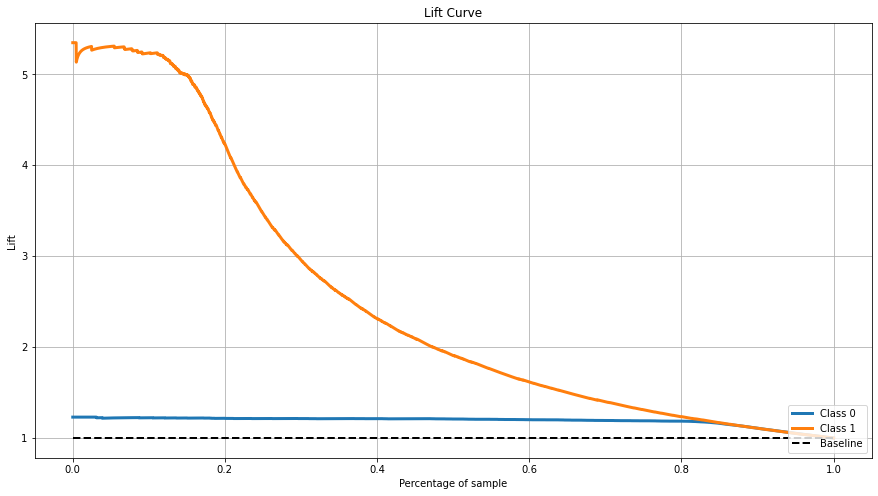

In [70]:
plot_lift_curve(lgb_model, X_test, y_test)